In [ ]:
#default_exp commit_graph

In [ ]:
#hide_output
%load_ext autoreload
%autoreload 2

# Extracting commit graphs from Git repositories
> Interacting with Git repositories in Python, extracting commit history from them, and turning it into NetworkX DiGraph

Imports for the `commit_graph` module

In [ ]:
#export
# creating graphs in Python
import networkx as nx
# calling git commands
import subprocess
# checking for existence of paths, and manipulating paths
from pathlib import Path

## Interacting with Git repositories in Python

There are various ways of interacting with Git repositories from Python code:

- shelling out and running `git` directly (for example using `import subprocess`)
- using [GitPython][] (`import git`)
- using [pygit2][] (`import pygit2`) - Python bindings to libgit2 library

[GitPython]: https://gitpython.readthedocs.io/
[pygit2]: https://www.pygit2.org/

**GitPython** is a python library used to interact with git repositories, high-level like git-porcelain, or low-level like git-plumbing.

It provides abstractions of git objects for easy access of repository data, and additionally allows you to access the git repository more directly using either a pure python implementation, or the faster, but more resource intensive git command implementation.

The object database implementation is optimized for handling large quantities of objects and large datasets, which is achieved by using low-level structures and data streaming. 

<u>_NOTE:_</u> Promisory objects (in sparse clone, `--filter=tree:0`) might be not supported.

```python
import git

repo = git.Repo.clone_from(url, path, ['--mirror', '--filter=tree:0'])
repo = git.Repo(path) # just open the repository
```

**Pygit2** is a set of Python bindings to the libgit2 shared library, libgit2 implements the core of Git.

<u>_NOTE:_</u> It is quite low level, and not everything is implemented yet (especially new features).

```python
import pygit2

pygit2.clone_repository(url, path, bare=True) # no support for filters?
repo = pygit2.Repository(path)
```

The **subprocess** module in the Python standard library allows you to spawn new processes, connect to their input/output/error pipes, and obtain their return codes.

The recommended approach to invoking subprocesses is to use the `run()` function for all use cases it can handle.

```python
import subprocess

subprocess.run(['git', 'clone', '--mirror', '--filter=tree:0', '--quiet', url, path])
```

## Cloning git.git repository, and extracting and saving the commit graph

Why it is important to use sparse clone - it is much faster, and takes up less space.  For example for git.git repository we have the following (all times are wall time, and subject to interference from other CPU load):
- full clone: 54s
- mirror: 1min 19s
- sparse: 14.9s - 19.4s

Prepare the directory to store repositories (note: `mkdir -d <directory>` should show no error if `<directory>` exists.  
Clone example repository (for exploration).

In [ ]:
Path("repos").mkdir(exist_ok=True)

In [ ]:
%%time
!git -C repos clone --mirror --filter=tree:0 --quiet https://github.com/git/git.git

Wall time: 14.9 s


Extract the history of the project

In [ ]:
Path("datasets").mkdir(exist_ok=True)

In [ ]:
%%time
!git -C repos/git.git log --format="%h %p" --topo-order --all >datasets/git-commit_graph.adjlist.txt

Wall time: 10.6 s


In [ ]:
%%time
graph_git = nx.read_adjlist("datasets/git-commit_graph.adjlist.txt", create_using=nx.DiGraph)
print('commit-graph of git repository graph has {} nodes and {} edges'.format(
      graph_git.number_of_nodes(),
      graph_git.number_of_edges()))
print('is directed:   {}'.format(graph_git.is_directed()))

commit-graph of git repository graph has 126983 nodes and 160534 edges
is directed:   True
Wall time: 4.13 s


In [ ]:
print('example nodes: {}'.format(list(graph_git.nodes)[:5]))

example nodes: ['836aadd78', 'a93475d10', '55fce44a3', '6d9d59c31', '084bd2a9a']


In [ ]:
# compress
%timeit nx.write_adjlist(graph_git, 'datasets/git-commit_graph.adjlist.txt.gz')

910 ms ± 43.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Testing different graph output formats

In [ ]:
#%%time
#nx.write_graph6(graph_git, 'datasets/git-commit_graph.g6')

It turns out that the [graph6 / sparse6 format](https://networkx.org/documentation/stable/reference/readwrite/sparsegraph6.html)
is not a good choice for storing the commit graph for the following reasons:
- NetworkX does not support digraph6 format; neither `write_graph6` not `write_sparse6` are implemented for directed graphs
- the [digraph6 format](http://users.cecs.anu.edu.au/~bdm/data/formats.txt) is dense graph format, storing the encoded adjacency matrix; there is no disparse6 or digraph6sparse format
- SparseGraph6 formats do not store node/vertex names, which might be needed for future computations or visualizations

In [ ]:
%time nx.write_edgelist(graph_git, 'datasets/git-commit_graph.edgelist.txt')
%time nx.write_multiline_adjlist(graph_git, 'datasets/git-commit_graph.multiline_adjlist.txt')
%time nx.write_gexf(graph_git, 'datasets/git-commit_graph.gexf.gz')
%time nx.write_gpickle(graph_git, 'datasets/git-commit_graph.gpickle.gz')
%time nx.write_graphml(graph_git, 'datasets/git-commit_graph.graphml.gz')
%time nx.write_pajek(graph_git, 'datasets/git-commit_graph.pajek.gz')

Wall time: 624 ms
Wall time: 456 ms
Wall time: 9.49 s
Wall time: 4.92 s
Wall time: 4.74 s
Wall time: 6.74 s


In [ ]:
import pandas as pd

In [ ]:
graph_git_df = nx.to_pandas_edgelist(graph_git)
graph_git_df

,source,target
0,836aadd78,a93475d10
1,836aadd78,55fce44a3
2,a93475d10,df525e622
3,55fce44a3,6d9d59c31
4,6d9d59c31,084bd2a9a
...,...,...
160529,24778e335,19b2860cb
160530,19b2860cb,bf0c6e839
160531,bf0c6e839,e497ea2a9
160532,e497ea2a9,8bc9a0c76


In [ ]:
%%time
graph_git_df.to_pickle('datasets/git-commit_graph.df_edgelist.pickle.gz')

Wall time: 1.9 s


In [ ]:
%%time
graph_git_df.to_csv('datasets/git-commit_graph.df_edgelist.csv.gz')

Wall time: 1.2 s


Both `to_feather()` and `to_parquet()` need `pyarrow` module installed (the latter might use `fastparquet` instead)

In [ ]:
%%time
try:
    graph_git_df.to_feather('datasets/git-commit_graph.df_edgelist.feather')
except ImportError:
    print("Missing optional dependency 'pyarrow' required to save dataframe to the feather format")

Wall time: 487 ms


In [ ]:
%%time
try:
    graph_git_df.to_parquet('datasets/git-commit_graph.df_edgelist.parquet')
except ImportError:
    print("Missing optional dependency 'pyarrow' or 'fastparquet' required to save dataframe to the parquet format")

Wall time: 157 ms


In [ ]:
%%time
graph_git_df.to_hdf('datasets/git-commit_graph.df_edgelist.hdf5', 'df_edgelist', mode='w', complevel=6)

Wall time: 244 ms


### Comparing the filesize of different graph output formats

In [ ]:
!dir datasets

 Volume in drive C has no label.
 Volume Serial Number is 1291-749D

 Directory of C:\Users\jnare\OneDrive\Dokumenty\GitHub\git-commit-graph-ext\datasets

14.12.2020  15:37    <DIR>          .
14.12.2020  15:37    <DIR>          ..
14.12.2020  11:45         2˙875˙179 git-commit_graph.adjlist.txt
14.12.2020  15:37         1˙173˙712 git-commit_graph.adjlist.txt.gz
14.12.2020  12:05         4˙383˙858 git-commit_graph.df_edgelist.csv
14.12.2020  12:05         1˙629˙263 git-commit_graph.df_edgelist.csv.gz
14.12.2020  11:45         3˙857˙818 git-commit_graph.df_edgelist.feather
14.12.2020  13:51         3˙808˙521 git-commit_graph.df_edgelist.hdf5
14.12.2020  11:45         3˙116˙020 git-commit_graph.df_edgelist.parquet
14.12.2020  11:45         1˙332˙691 git-commit_graph.df_edgelist.pickle.gz
14.12.2020  12:32         3˙692˙282 git-commit_graph.edgelist.txt
14.12.2020  12:32         3˙063˙783 git-commit_graph.gexf.gz
14.12.2020  12:32         3˙254˙690 git-commit_graph.gpickle.gz
14.12.2020  

In [ ]:
import io

csv = u"""filename;size [bytes];size uncompressed [bytes];time [s]
git-commit_graph.adjlist.txt;2875179;2875179
git-commit_graph.adjlist.txt.gz;1173712;2875369;0.910
git-commit_graph.multiline_adjlist.txt;3610938;3610938;0.456
git-commit_graph.edgelist.txt;3692282;3692282;0.624
git-commit_graph.gpickle.gz;3254690;7712162;4.92
git-commit_graph.gexf.gz;3063783;16419236;9.49
git-commit_graph.graphml.gz;2231397;10305482;4.74
git-commit_graph.pajek.gz;1754236;6682509;6.74
git-commit_graph.df_edgelist.pickle.gz;1332691;2736191;1.9
git-commit_graph.df_edgelist.feather;3857818;3857818;0.487
git-commit_graph.df_edgelist.parquet;3116020;3116020;0.333
git-commit_graph.df_edgelist.csv;4383858;4383858
git-commit_graph.df_edgelist.csv.gz;1629263;4383858;1.2
git-commit_graph.df_edgelist.hdf5;3808521;5077784;0.244
"""

csv_stream = io.StringIO(csv)
table_sizes=pd.read_csv(csv_stream,sep=';') # ,index_col=0
table_sizes

,filename,size [bytes],size uncompressed [bytes],time [s]
0,git-commit_graph.adjlist.txt,2875179,2875179,NaN
1,git-commit_graph.adjlist.txt.gz,1173712,2875369,0.910
2,git-commit_graph.multiline_adjlist.txt,3610938,3610938,0.456
3,git-commit_graph.edgelist.txt,3692282,3692282,0.624
4,git-commit_graph.gpickle.gz,3254690,7712162,4.920
5,git-commit_graph.gexf.gz,3063783,16419236,9.490
6,git-commit_graph.graphml.gz,2231397,10305482,4.740
7,git-commit_graph.pajek.gz,1754236,6682509,6.740
8,git-commit_graph.df_edgelist.pickle.gz,1332691,2736191,1.900
9,git-commit_graph.df_edgelist.feather,3857818,3857818,0.487


In [ ]:
table_sizes.dtypes

filename                      object
size [bytes]                   int64
size uncompressed [bytes]      int64
time [s]                     float64
dtype: object

In [ ]:
table_sizes.sort_values(by='size [bytes]')

,filename,size [bytes],size uncompressed [bytes],time [s]
1,git-commit_graph.adjlist.txt.gz,1173712,2875179,0.910
8,git-commit_graph.df_edgelist.pickle.gz,1332691,2736191,1.900
12,git-commit_graph.df_edgelist.csv.gz,1629263,4383858,1.200
7,git-commit_graph.pajek.gz,1754236,6682509,6.740
6,git-commit_graph.graphml.gz,2231397,10305482,4.740
0,git-commit_graph.adjlist.txt,2875179,2875179,NaN
5,git-commit_graph.gexf.gz,3063783,16419236,9.490
10,git-commit_graph.df_edgelist.parquet,3116020,3116020,0.333
4,git-commit_graph.gpickle.gz,3254690,7712162,4.920
2,git-commit_graph.multiline_adjlist.txt,3610938,3610938,0.456


In [ ]:
table_sizes.sort_values(by='size uncompressed [bytes]')

,filename,size [bytes],size uncompressed [bytes],time [s]
8,git-commit_graph.df_edgelist.pickle.gz,1332691,2736191,1.900
0,git-commit_graph.adjlist.txt,2875179,2875179,NaN
1,git-commit_graph.adjlist.txt.gz,1173712,2875179,0.910
10,git-commit_graph.df_edgelist.parquet,3116020,3116020,0.333
2,git-commit_graph.multiline_adjlist.txt,3610938,3610938,0.456
3,git-commit_graph.edgelist.txt,3692282,3610938,0.624
9,git-commit_graph.df_edgelist.feather,3857818,3857818,0.487
11,git-commit_graph.df_edgelist.csv,4383858,4383858,NaN
12,git-commit_graph.df_edgelist.csv.gz,1629263,4383858,1.200
13,git-commit_graph.df_edgelist.hdf5,3808521,5077784,0.244


### Summary of findings

<u>Storing DataFrame of edgelist data</u>

The DataFrame is created using `nx.to_pandas_edgelist(graph)`

The smallest file is the result of storing DataFrame of edgelist data as gzipped pickle (written using Pandas' `to_pickle()`) - the **\*.df_edgelist.pickle.gz** file.

- Advantages:
  - 2nd smallest size
  - no extra modules to install
  - preserves types
- Disadvantages:
  - Python-specific
  - unsafe
  - slow (?)

Next smallest is, surprisingly, gzipped CSV representing DataFrame of edgelist data (written using Pandas' `to_csv()`) - the **\*.df_edgelist.csv.gz** file.

- Advantages:
  - 3rd smallest size
  - no extra modules to install
  - universal format
- Disadvantages:
  - slow (?)

The fast interchange formats, [Feather](https://github.com/wesm/feather) and [Parquet](https://parquet.apache.org/) turned out to produce quite large files; they are however 4th smallest and 2nd smallest, respectively, among uncompressed formats.

**_Feather_** provides a binary columnar serialization for data frames. It is designed to make reading and writing data frames efficient, and to make sharing data across data analysis languages easy.

Feather is designed to faithfully serialize and de-serialize `DataFrame`s, supporting all of the pandas dtypes, including extension dtypes such as categorical and datetime with tz.

**_Apache Parquet_** provides a _partitioned_ binary columnar serialization for data frames. It is designed to make reading and writing data frames efficient, and to make sharing data across data analysis languages easy. Parquet can use a variety of compression techniques (default is to use 'snappy') to shrink the file size as much as possible while still maintaining good read performance.

Parquet is designed to faithfully serialize and de-serialize `DataFrame`s, supporting all of the pandas dtypes, including extension dtypes such as datetime with tz.

- Advantages:
  - universal, cross language
  - preserves types
  - fast
- Disadvantages:
  - requires `pyarrow` package to be installed
  - quite large file size

The **_HDF5_** format has the advantage of being able to store multiple `DataFrame`s in a single file, for example one `DataFrame` to hold edgelist data to define the graph connections, and one `DataFrame` holding various per vertex (per node) rechablity index data.  Unfortunately, even internally compressed it has one of larger file sizes (and largest compressed).

[Hierarchical Data Format (HDF)](https://portal.hdfgroup.org/display/HDF5/HDF5) is self-describing, allowing an application to interpret the structure and contents of a file with no outside information. One HDF file can hold a mix of related objects which can be accessed as a group or as individual objects.

The `to_hdf()` method in Pandas uses the `HDFStore` in the background, which in turn utilizes the [PyTables](https://www.pytables.org/) library.

- Advantages:
  - universal, cross language
  - preserves types
  - no extra modules to install (?)
  - can store multiple `DataFrame`s
- Disadvantages:
  - large file size
  - slow (?)
  - unsafe (because of serializing object-dtype data with pickle)

----
<u>Storing NetworkX DiGraph directly</u>

Except for the adjacency lists format (**\*.adjlist.txt**), which cannot store any additional data (not even per-edge), the multi-line adjacency lists (**\*.multiline_adjlist.txt**) and edge lists (**\*.edgelist.txt**) formats have file sizes larger than the Parquet storing `DataFrame` of edge lists.  Note however that they are uncompressed.

The adjacency list format can be created directly by appropriate Git command.

Because those formats cannot store per-node data, they are not considered for use.

Among specialized graph file formats, which I assume can store both per-node and per-edge data, **_Pajek_** format is smallest (compressed), and 4th smallest among all considered storage formats.  It is also smallest uncompressed among similar file formats.

Writing NetworkX graphs as Python pickles using `write_gpickle()` (\***.gpickle.gz**) results in quite large file compressed, one of the largest files uncompressed.

On the other hand NetworkX graphs can contain any hashable Python object as node (not just integers and strings). For arbitrary data types it may be difficult to represent the data as text. In that case using Python pickles to store the graph data can be used.

## Examining computing and storing reachability labels and other per-node data

In [ ]:
from git_commit_graph_ext.labelling.levels import *
from git_commit_graph_ext.labelling.dfs_intervals import *

In [ ]:
import numpy as np

### Computing reachability labels for git.git commit graph

In [ ]:
print('git.git commit graph')
graph = graph_git

print('graph has {} nodes and {} edges'.format(graph.number_of_nodes(), graph.number_of_edges()))

print('find levels:')
%time graph.lvl = find_levels(graph)
print('\nfind min-post intervals:')
%time graph.mpi = find_dfs_intervals(graph)
print('\nfind min-post intervals (graph+tree):')
%time graph.mpi_ext = find_dfs_intervals_extra(graph)

git.git commit graph
graph has 126983 nodes and 160534 edges
find levels:
Wall time: 4.66 s

find min-post intervals:
Wall time: 11.1 s

find min-post intervals (graph+tree):
Wall time: 3.94 s


All times to calculate different graph indices for git.git commit graph take around few second.

In [ ]:
# calculating parameters of the git.git commit graphs: distribution of in-degree, out-degree and level
print('git.git commit graph')
graph = graph_git

graph_info_df=pd.DataFrame.from_dict(graph.lvl,orient='index').rename(columns={0: 'level'})
graph_info_df.index.name='node'
graph_info_df['in degree']=pd.Series(dict(graph.in_degree()))
graph_info_df['out degree']=pd.Series(dict(graph.out_degree()))

graph_info_df = pd.concat([graph_info_df,
                           pd.DataFrame.from_dict(graph.mpi_ext,orient='index',columns=['f_min','min','post'])],
                          axis=1,join='inner')

graph_info_df

git.git commit graph


,level,in degree,out degree,f_min,min,post
e83c51633,0,1,0,1,1,1
8bc9a0c76,1,1,1,1,1,2
e497ea2a9,2,1,1,1,1,3
bf0c6e839,3,1,1,1,1,4
19b2860cb,4,1,1,1,1,5
...,...,...,...,...,...,...
6380b97d5,10986,1,1,1,126951,126979
ca865d923,10987,1,1,1,126951,126980
84b4fb665,10988,1,1,1,126951,126981
38970e663,10989,1,1,1,126951,126982


In [ ]:
graph_info_df.dtypes

level         int64
in degree     int64
out degree    int64
f_min         int64
min           int64
post          int64
dtype: object

In [ ]:
graph_info_df.describe()

,level,in degree,out degree,f_min,min,post
count,126983.000000,126983.000000,126983.000000,126983.000000,126983.000000,126983.000000
mean,17096.879448,1.264216,1.264216,1070.047455,57752.315034,63492.000000
std,8805.617403,1.753767,0.443233,7630.315032,40076.581628,36656.978954
min,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
25%,11575.500000,1.000000,1.000000,1.000000,21636.000000,31746.500000
50%,16893.000000,1.000000,1.000000,1.000000,61901.000000,63492.000000
75%,20930.000000,1.000000,2.000000,1.000000,91690.000000,95237.500000
max,37458.000000,115.000000,10.000000,62460.000000,126951.000000,126983.000000


### Visualizing topological level stats for git.git commit graph

Imports for plots

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
sns.set()

Histogram for backward topological levels

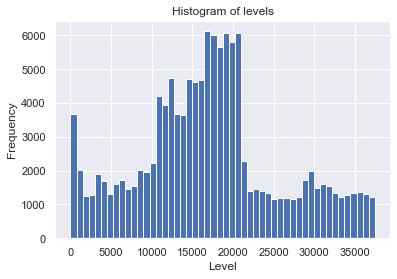

In [ ]:
plt.title('Histogram of levels')
plt.xlabel('Level')
graph_info_df['level'].plot.hist(bins=50)
plt.draw()

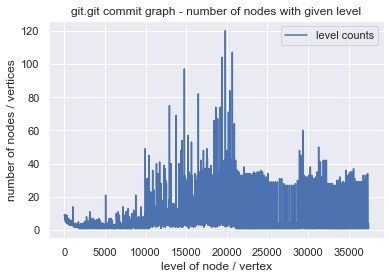

In [ ]:
level_counts=graph_info_df['level'].value_counts()

level_counts_df=pd.DataFrame({'level counts': level_counts})
level_counts_df.index.name='level'
level_counts_df.sort_index(inplace=True)
level_counts_df.plot()

plt.title('%s commit graph - number of nodes with given level' %
          'git.git')
plt.xlabel('level of node / vertex')
plt.ylabel('number of nodes / vertices')
plt.show()

count    37459.000000
mean         3.389920
std          4.309552
min          1.000000
25%          1.000000
50%          2.000000
75%          4.000000
max        120.000000
Name: level, dtype: float64

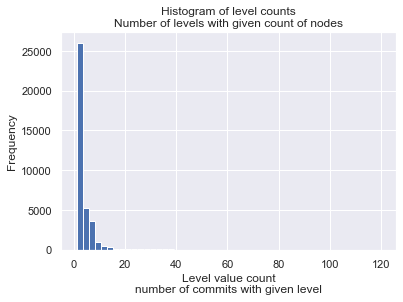

In [ ]:
level_counts=graph_info_df['level'].value_counts()

plt.title('Histogram of level counts\n'+'Number of levels with given count of nodes')
plt.xlabel('Level value count\n'+'number of commits with given level')
level_counts.plot.hist(bins=50)

level_counts.describe()

Sanity checking the computed level counts; nodes with backward topological level of zero are sink nodes, with out-degree of 0.

Thus the number of nodes with level of 0 should be equal to number of nodes with out-degree of 0.

In [ ]:
# sanity checking level counts

print('git.git commit graph')
graph = graph_git

sinks  =[n for n in graph if graph.out_degree(n) == 0]
sources=[n for n in graph if graph.in_degree(n)  == 0]
print('there are {:3d} nodes with  in-degree of 0'.format(len(sources)))
print('there are {:3d} nodes with out-degree of 0: {}'.format(len(sinks),sinks))
print('there are {:3d} nodes with level of 0'.format(level_counts.at[0]))

graph_info_df[graph_info_df['level']==0]

git.git commit graph
there are 868 nodes with  in-degree of 0
there are   9 nodes with out-degree of 0: ['7d77f2e9c', '1bd90415d', '0ca71b373', '16d6b8ab6', 'cb07fc2a2', '161332a52', '2744b2344', '1db95b00a', 'e83c51633']
there are   9 nodes with level of 0


,level,in degree,out degree,f_min,min,post
e83c51633,0,1,0,1,1,1
1db95b00a,0,1,0,799,799,799
2744b2344,0,1,0,1149,1149,1149
161332a52,0,1,0,5044,5044,5044
cb07fc2a2,0,1,0,8137,8137,8137
16d6b8ab6,0,1,0,10300,10300,10300
0ca71b373,0,1,0,28384,28384,28384
1bd90415d,0,1,0,61901,61901,61901
7d77f2e9c,0,1,0,62460,62460,62460


### Visualizing in-degree and out-degree in git.git commit graph

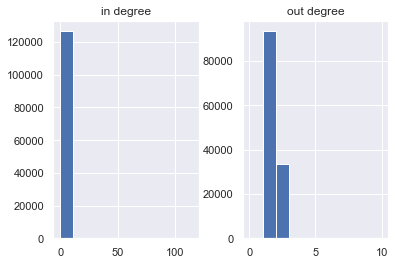

In [ ]:
graph_info_df[['in degree','out degree']].hist(bins=10)
plt.show()

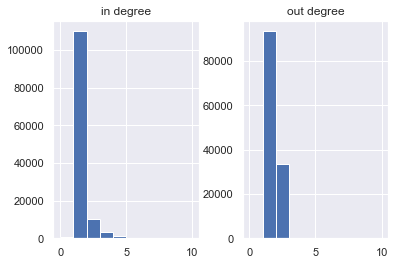

In [ ]:
graph_info_df.hist(column=['in degree','out degree'],bins=10,range=(0,10))
plt.show()

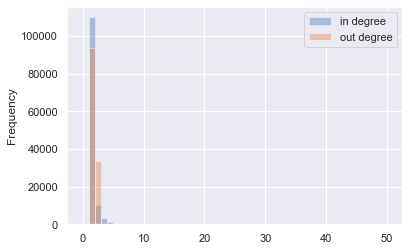

In [ ]:
graph_info_df[['in degree','out degree']].plot.hist(bins=51,alpha=0.4,range=(0,50))
plt.show()

### Visualizing min-post intervals in git.git commit graphs

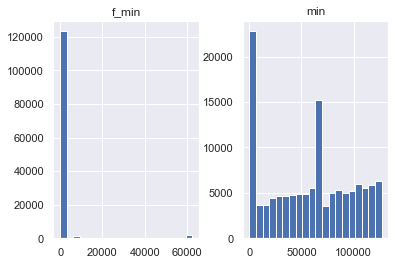

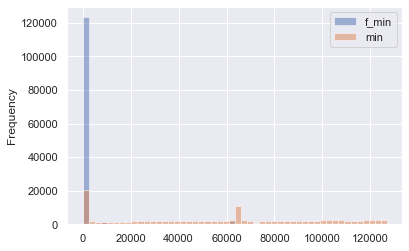

In [ ]:
graph_info_df.hist(column=['f_min','min'],bins=20)
graph_info_df[['f_min','min']].plot.hist(bins=50,alpha=0.5)
plt.show()

In [ ]:
graph_info_df['|interval|']=graph_info_df['post'] - graph_info_df['min']
graph_info_df['|interval|/post']=graph_info_df['|interval|']/graph_info_df['post']
graph_info_df['|f_interval|']=graph_info_df['post'] - graph_info_df['f_min']
graph_info_df['|f_interval|/post']=graph_info_df['|f_interval|']/graph_info_df['post']
graph_info_df

,level,in degree,out degree,f_min,min,post,|interval|,|interval|/post,|f_interval|,|f_interval|/post
e83c51633,0,1,0,1,1,1,0,0.000000,0,0.000000
8bc9a0c76,1,1,1,1,1,2,1,0.500000,1,0.500000
e497ea2a9,2,1,1,1,1,3,2,0.666667,2,0.666667
bf0c6e839,3,1,1,1,1,4,3,0.750000,3,0.750000
19b2860cb,4,1,1,1,1,5,4,0.800000,4,0.800000
...,...,...,...,...,...,...,...,...,...,...
6380b97d5,10986,1,1,1,126951,126979,28,0.000221,126978,0.999992
ca865d923,10987,1,1,1,126951,126980,29,0.000228,126979,0.999992
84b4fb665,10988,1,1,1,126951,126981,30,0.000236,126980,0.999992
38970e663,10989,1,1,1,126951,126982,31,0.000244,126981,0.999992


In [ ]:
graph_info_df.describe()

,level,in degree,out degree,f_min,min,post,|interval|,|interval|/post,|f_interval|,|f_interval|/post
count,126983.000000,126983.000000,126983.000000,126983.000000,126983.000000,126983.000000,126983.000000,126983.000000,126983.000000,126983.000000
mean,17096.879448,1.264216,1.264216,1070.047455,57752.315034,63492.000000,5739.684966,0.170924,62421.952545,0.973793
std,8805.617403,1.753767,0.443233,7630.315032,40076.581628,36656.978954,13327.586969,0.358340,37623.375884,0.152607
min,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,11575.500000,1.000000,1.000000,1.000000,21636.000000,31746.500000,1.000000,0.000022,29785.500000,0.999966
50%,16893.000000,1.000000,1.000000,1.000000,61901.000000,63492.000000,9.000000,0.000178,61578.000000,0.999984
75%,20930.000000,1.000000,2.000000,1.000000,91690.000000,95237.500000,222.000000,0.006874,95235.500000,0.999989
max,37458.000000,115.000000,10.000000,62460.000000,126951.000000,126983.000000,61747.000000,0.999984,126982.000000,0.999992


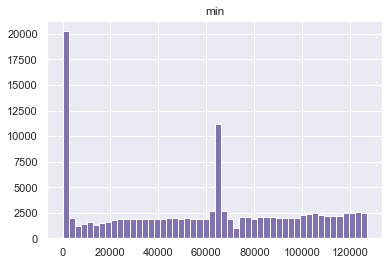

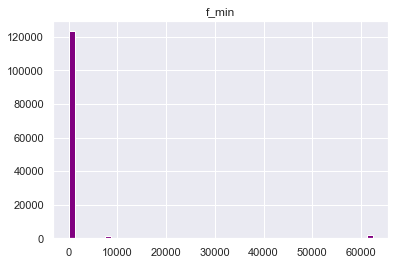

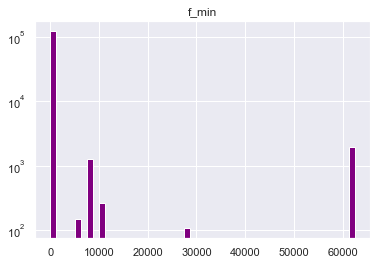

In [ ]:
graph_info_df.hist(column=['min'],bins=50,color='m')
graph_info_df.hist(column=['f_min'],bins=50,color='#800080')
graph_info_df.hist(column=['f_min'],bins=50,log=True,color='#800080')
plt.show()

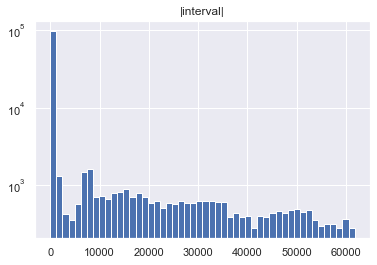

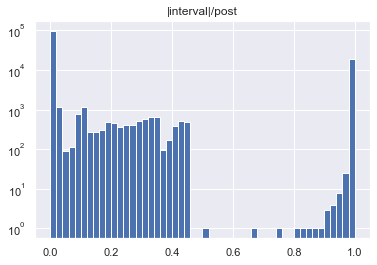

In [ ]:
graph_info_df.hist(column=['|interval|'],bins=50,log=True)
graph_info_df.hist(column=['|interval|/post'],bins=50,log=True)
plt.show()

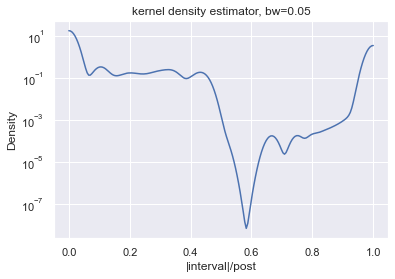

In [ ]:
graph_info_df['|interval|/post'].plot.kde(bw_method=0.05,ind=np.linspace(0,1,200))
plt.title('kernel density estimator, bw=0.05, logscale')
plt.xlabel('|interval|/post')
plt.gca().set_yscale("log", nonpositive='clip')
plt.show()

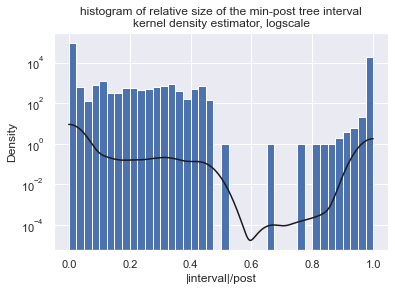

In [ ]:
graph_info_df.hist(column=['|interval|/post'],bins=40,log=True)
graph_info_df['|interval|/post'].plot.kde(ind=np.linspace(0,1,500),color='k')
plt.title('histogram of relative size of the min-post tree interval\n'+'kernel density estimator, logscale')
plt.xlabel('|interval|/post')
plt.gca().set_yscale("log", nonpositive='clip')
plt.show()

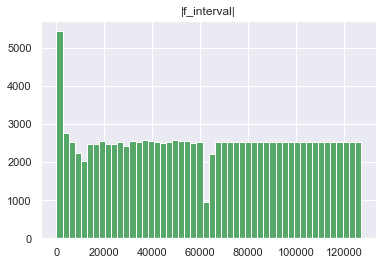

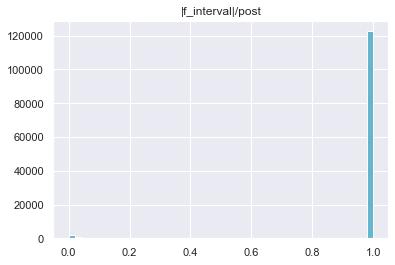

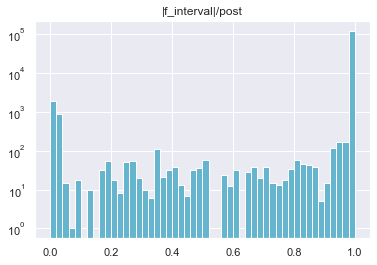

In [ ]:
graph_info_df.hist(column=['|f_interval|'],bins=50,color='g')
graph_info_df.hist(column=['|f_interval|/post'],bins=50,color='c')
graph_info_df.hist(column=['|f_interval|/post'],bins=50,log=True,color='c')
plt.show()

### Storing computed reachability labels and related stats

In [ ]:
from shutil import copyfile
copyfile('datasets/git-commit_graph.df_edgelist.hdf5', 'datasets/git-commit_graph.hdf5')

'datasets/git-commit_graph.hdf5'

In [ ]:
print('pickle.gz: ', end=' ', flush=True)
%time graph_info_df.to_pickle('datasets/git-commit_graph.info.pickle.gz')
print('csv.gz:    ', end=' ', flush=True)
%time graph_info_df.to_csv('datasets/git-commit_graph.info.csv.gz')
print('hdf (full):', end=' ', flush=True)
%time graph_info_df.to_hdf('datasets/git-commit_graph.info.hdf5', 'df', mode='w', complevel=6)
print('hdf (appd):', end=' ', flush=True)
%time graph_info_df.to_hdf('datasets/git-commit_graph.hdf5', 'df_info', mode='a', complevel=6)

pickle.gz:  Wall time: 6.77 s
csv.gz:     Wall time: 5.45 s
hdf (full): Wall time: 664 ms
hdf (appd): Wall time: 840 ms


In [ ]:
# feather does not support non-numerical index, IIRC
#%time graph_info_df.to_feather('datasets/git-commit_graph.info.feather')

In [ ]:
%%time
try:
    graph_info_df.to_parquet('datasets/git-commit_graph.info.parquet')
except ImportError:
    print("Missing optional dependency 'pyarrow' required")

Wall time: 423 ms


In [ ]:
!dir datasets

 Volume in drive C has no label.
 Volume Serial Number is 1291-749D

 Directory of C:\Users\jnare\OneDrive\Dokumenty\GitHub\git-commit-graph-ext\datasets

15.12.2020  01:20    <DIR>          .
15.12.2020  01:20    <DIR>          ..
14.12.2020  11:45         2˙875˙179 git-commit_graph.adjlist.txt
14.12.2020  15:37         1˙173˙712 git-commit_graph.adjlist.txt.gz
14.12.2020  12:05         4˙383˙858 git-commit_graph.df_edgelist.csv
14.12.2020  12:05         1˙629˙263 git-commit_graph.df_edgelist.csv.gz
14.12.2020  11:45         3˙857˙818 git-commit_graph.df_edgelist.feather
14.12.2020  13:51         3˙808˙521 git-commit_graph.df_edgelist.hdf5
15.12.2020  01:20         3˙116˙020 git-commit_graph.df_edgelist.parquet
14.12.2020  11:45         1˙332˙691 git-commit_graph.df_edgelist.pickle.gz
14.12.2020  12:32         3˙692˙282 git-commit_graph.edgelist.txt
14.12.2020  12:32         3˙063˙783 git-commit_graph.gexf.gz
14.12.2020  12:32         3˙254˙690 git-commit_graph.gpickle.gz
14.12.2020  

In [ ]:
csv = u"""filename;size [bytes];time [s]
datasets/git-commit_graph.info.pickle.gz;2833650;6.8
datasets/git-commit_graph.info.csv.gz;3681511;5.26
datasets/git-commit_graph.info.parquet;6079159;0.345 
datasets/git-commit_graph.info.hdf5;2735986;0.674
datasets/git-commit_graph.hdf5;6548777;0.672
"""

csv_stream = io.StringIO(csv)
table_sizes_2=pd.read_csv(csv_stream,sep=';') # ,index_col=0
table_sizes_2

,filename,size [bytes],time [s]
0,datasets/git-commit_graph.info.pickle.gz,2833650,6.800
1,datasets/git-commit_graph.info.csv.gz,3681511,5.260
2,datasets/git-commit_graph.info.parquet,6079159,0.345
3,datasets/git-commit_graph.info.hdf5,2735986,0.674
4,datasets/git-commit_graph.hdf5,6548777,0.672


In [ ]:
table_sizes_2.sort_values(by='size [bytes]')

,filename,size [bytes],time [s]
3,datasets/git-commit_graph.info.hdf5,2735986,0.674
0,datasets/git-commit_graph.info.pickle.gz,2833650,6.800
1,datasets/git-commit_graph.info.csv.gz,3681511,5.260
2,datasets/git-commit_graph.info.parquet,6079159,0.345
4,datasets/git-commit_graph.hdf5,6548777,0.672


In [ ]:
table_sizes_2.sort_values(by='time [s]')

,filename,size [bytes],time [s]
2,datasets/git-commit_graph.info.parquet,6079159,0.345
4,datasets/git-commit_graph.hdf5,6548777,0.672
3,datasets/git-commit_graph.info.hdf5,2735986,0.674
1,datasets/git-commit_graph.info.csv.gz,3681511,5.260
0,datasets/git-commit_graph.info.pickle.gz,2833650,6.800


### Summary of findings

Strangely,smallest files size this time is given when storing using the **_HDF5_** (with `compresslevel=6`) format, which is also 2nd fastest.

Saving `DataFrame` using the **_Parquet_** format is fastest, but this time it gives the largest size of the file

Saving as **\*.pickle.gz** or **\*.csv.gz** is slowest and second slowest, while both being in the middlle with respect to file sizes (the pickle-based format gives smaller file size).

## Functions for creating the commit-graph out of repository, computing labelling, etc

### Functions for cloning the repository

Because the repository is needed only to extract the commit graph from it, therefore to save time and disk space sparse clone will be used.

This strongly suggests using the Git command line.

In [ ]:
#export
def sparse_clone(url, repo_name=None, repos_dir="repos"):
    """Clone Git repository by URL using sparse/partial clone

    The "Sparse Clone" or the "Partial Clone" feature is a performance
    optimization for Git that allows Git to function without having
    a complete copy of the repository.  The goal of this feature is to allow
    Git better handle extremely large repositories, or in this case store
    the repository using less disk space.

    To retrieve the commit graph out of the git repository only commit
    objects are needed, so all tree and blob objects can be omitted from the
    clone.

    Using sparse clone is much more efficient: the process is faster, and
    the resulting repository takes much less disk space than full clone.

    NOTE: Use of partial clone requires that the user be online and the origin
    remote or other promisor remotes be available for on-demand fetching
    of missing objects, unless the user can stay within the pre-selected
    subset of objects.

    see: https://git-scm.com/docs/git-clone
    see: https://git-scm.com/docs/git-rev-list#Documentation/git-rev-list.txt---filterltfilter-specgt
    see: https://github.com/git/git/blob/master/Documentation/technical/partial-clone.txt

    Parameters
    ----------
    url : str
        The repository to be cloned, in most cases it would be public URL
        that can be used to clone the remote repository.

    repo_name: str
        The name of a new directory to clone into. The "humanish" part of
        the source repository (of the `url` parameter) is used if no directory
        is explicitly given (`repo` for `/path/to/repo.git` and `foo` for
        `host.xz:foo/.git`).  Cloning into an existing directory is only
        allowed if the directory is empty.

    repos_dir : str
        The directory where to put cloned repository into.
        By default "repos" is used.
    """
    cmd = ['git']
    if repos_dir:
        cmd.extend(['-C', repos_dir])
    cmd.extend(['clone', '--mirror', '--filter=tree:0', '--quiet', url])
    if repo_name:
        cmd.append(repo_name)
    subprocess.run(cmd)

If repository exists, there is no need to clone it

In [ ]:
#export
def get_repo(url, repo_path, refresh=False):
    """Clone Git repository into given path, if needed

    If the path given by `repo_path` does not exist, or `refresh` is true,
    clone Git repository at `url` for later extraction of the commit graph.

    see: `sparse_clone()`

    Parameters
    ----------
    url : str
        The repository to be cloned, in most cases it would be public URL
        that can be used to clone the remote repository.

    repo_path: str
        The pathname under which one can find resulting Git repository.

    refresh: bool
        Whether to re-clone the repository if `repo_path` path exists.
        Default is false, to not perform a clone if not needed.
    """
    if refresh or not Path(repo_path).exists():
        sparse_clone(url, repo_name=repo_path, repos_dir="")

### Functions for extracting the commit graph out of git repository

Using Git commands, we can easily create text file that store commit-graph information in the adjacency list format, from which it is easy to create a NetworkX graph (`DiGraph`).  Shortened object identifiers (shortened SHA-1) will be used to identify commits which are nodes / vertices of the commit graph.

In [ ]:
#export
def _repo_name_to_out_path(repo_path, out_dir="datasets"):
    """Create filename for storing adjacency list out of repository path

    This is a helper function used, among others, in `repo_generate_adjlist()`
    and `repo_adjlist_to_graph()`.

    Parameters
    ----------
    repo_path : str
        Path to the Git repository

    out_dir : str
        Directory where extracted commit graph data would be stored.
        Defaults to "datasets".

    Returns
    -------
    Path
        Path to the file storing the commit graph in the adjacency list
        file format.

        see: https://networkx.org/documentation/stable/reference/readwrite/adjlist.html
    """
    # The `out_dir` should not be None
    if out_dir is None:
        out_dir = "."
    # generate the name of the output file, as `pathlib.Path` object
    # removing the '*.git' extension / suffix from `repo_path`, if needed
    out_pathname = Path(out_dir) / (Path(repo_path).stem + "-commit_graph.adjlist.txt")

    return out_pathname


def repo_generate_adjlist(repo_path, out_dir="datasets", refresh=False):
    """Generate graph of revisions in the adjacency list format

    Can be read with `nx.read_adjlist()`; don't forget to ensure that
    NetworkX generates _directed_ graph.

    >>>> path = repo_generate_adjlist("repos/git.git")
    >>>> graph = nx.read_adjlist(path, create_using=nx.DiGraph)

    By default it does not recreate the file if it exists already,
    unless `refresh=True` argument is passed.

    Format
    ------
    The adjacency list format consists of lines with node labels.  The first
    label in a line is the source node. Further labels in the line are
    considered target nodes and are added to the graph along with an edge
    between the source node and target node.

    The graph with edges a-b, a-c, d-e can be represented as the following
    adjacency list (anything following the # in a line is a comment):

    > a b c # source target target
    > d e

    see: https://networkx.org/documentation/stable/reference/readwrite/adjlist.html

    Parameters
    ----------
    repo_path : str
        Path to the Git repository

    out_dir : str
        Directory where extracted commit graph data would be stored.
        Defaults to "datasets".

    refresh : bool
        Whether to regenerate the file with the commit graph in adjacency
        format if it exists.  Defaults to false.

    Returns
    -------
    Path
        Path where the commit graph in the adjacency file format
        can be found.
    """
    out_pathname = _repo_name_to_out_path(repo_path, out_dir=out_dir)
    # generate the adjacency list using git-log command
    if refresh or not out_pathname.exists():
        with out_pathname.open("w") as outfile:
            subprocess.run(['git', '-C', repo_path,
                            'log', '--format="%h %p"', '--topo-order', '--all'],
                           stdout=outfile)
    return out_pathname

To process the commit graph, we need to create a NetworkX directed graph from it, using generated adjacency list file.

In [ ]:
#export
def repo_adjlist_to_graph(repo_path, datasets_dir="datasets"):
    """Create `DiGraph` out of adjacency list file created from it

    NOTE: the `repo_to_graph()` function is safer to use, as it generates
    the graph of commits in the adjacency list file format of needed.

    Parameters
    ----------
    repo_path : str
        Path to the Git repository

    datasets_dir : str
        Directory where extracted commit graph data would be stored.
        Defaults to "datasets".

    Returns
    -------
    nx.DiGraph
        Directed graph of revisions as NetworkX's `DiGraph`
    """
    out_pathname = _repo_name_to_out_path(repo_path, out_dir=datasets_dir)
    return nx.read_adjlist(out_pathname, create_using=nx.DiGraph)

Tying it all together, to get a directed graph of revision history of a given repository into NetworkX `DiGraph`, we need to create a sparse clone of a repository if it does not exist, write log of revision history in adjacency list format if the file does not exist, and create the commit graph as NetworkX `DiGraph`.

In [ ]:
#export
def repo_to_graph(repo_path, datasets_dir="datasets", refresh=False):
    """Create a graph of commits for given local repository

    It uses existing file with the commit graph in the adjacency list file
    format, unless refresh is requested with `refresh=True`.  Automatically
    generates such file if it does not exist.

    Parameters
    ----------
    repo_path : str
        Path to the local Git repository

    datasets_dir : str
        Directory where extracted commit graph data can be stored, or will
        be stored.  Defaults to "datasets".

    refresh : bool
        Whether to regenerate the file with the commit graph in adjacency
        format if it exists.  Defaults to false.

    Returns
    -------
    nx.DiGraph
        Directed graph of revisions as NetworkX's `DiGraph`
    """
    out_pathname = repo_generate_adjlist(repo_path, out_dir=datasets_dir, refresh=refresh)
    return nx.read_adjlist(out_pathname, create_using=nx.DiGraph)


def commit_graph(url, repo_name,
                 repos_dir="repos", datasets_dir="datasets",
                 reclone=False, rescan=False):
    """Create a graph of commits for given remote repository, stored locally

    Given a Git repository `url`, clone it as `repo_name` in `repo_dir`
    directory, then create a graph of its commits as NetworkX `DiGraph`.

    Avoids re-cloning of the remote repository unless `reclone=True` is
    passed, and avoids rescanning the local copy of the repository if file
    in the adjacency list format with the commit graph information exists
    unless `rescan=True` is passed.

    Parameters
    ----------
    url : str
        The repository to be cloned, in most cases it would be public URL
        that can be used to clone the remote repository.

    repo_name: str
        The name of a new directory to clone into (or in other words name
        of local clone of the remote repository).

    repos_dir : str
        The directory where to put cloned repository into.
        By default "repos" is used.

    datasets_dir : str
        Directory where extracted commit graph data can be stored, or will
        be stored.  Defaults to "datasets".

    reclone : bool
        Whether to re-clone the repository if the local clone exists.
        Default is false, to not perform a clone if not needed.

    rescan : bool
        Whether to regenerate the file with the commit graph in adjacency
        format if it exists.  Defaults to false.

    Returns
    -------
    nx.DiGraph
        Directed graph of revisions as NetworkX's `DiGraph`
    """
    repo_path = Path(repos_dir) / repo_name
    get_repo(url, repo_path, refresh=reclone)
    return repo_to_graph(repo_path, datasets_dir=datasets_dir, refresh=rescan)

### Functions for computing reachability labels, and saving them and graph to a file (TODO)

----

In [ ]:
#hide
# this should be the last cell of the notebook
from nbdev.export import notebook2script
notebook2script()

Converted 01_tools.ipynb.
Converted 02_related.ipynb.
Converted 03_example_graphs.ipynb.
Converted 05_reachability_index.ipynb.
Converted 06_levels.ipynb.
Converted 07_interval_labels.ipynb.
Converted 08_reach.ipynb.
Converted 09_git.ipynb.
Converted index.ipynb.
